In [8]:
from pathlib import Path
import numpy as np
import matplotlib.pyplot as plt
import xarray as xr
import polars as pl
from jetutils.definitions import DATADIR, xarray_to_polars
from jetutils.data import standardize, DataHandler
from jetutils.jet_finding import JetFindingExperiment
import colormaps
from matplotlib.colors import Normalize, BoundaryNorm
from matplotlib.cm import ScalarMappable

In [10]:
dh = DataHandler.from_specs("ERA5", "plev", ("high_wind", None), "6H", (2005, 2025), [5, 6, 7, 8, 9], -80, 40, 15,  80)
exp = JetFindingExperiment(dh)
ds = exp.ds
all_jets_one_df = exp.find_jets(force=False, base_s_thresh=0.55, hole_size=6)
all_jets_one_df = exp.categorize_jets(None, ["s", "theta"], force=False, n_init=10, init_params="k-means++", mode="week").cast({"time": pl.Datetime("ms")})
props_uncat = exp.props_as_df(False).cast({"time": pl.Datetime("ms")})

In a future version of xarray the default value for join will change from join='outer' to join='exact'. This change will result in the following ValueError: cannot be aligned with join='exact' because index/labels/sizes are not equal along these coordinates (dimensions): 'lat' ('lat',) The recommendation is to set join explicitly for this case.


[########################################] | 100% Completed | 356.61 s


100%|██████████| 20/20 [03:55<00:00, 11.80s/it]


In [3]:
basepath = Path(DATADIR, "S2S", "surf")
ref = standardize(xr.open_dataarray(basepath.joinpath("mslp_era5/daily/full.nc")))

In [4]:
ref

<xarray.DataArray 'msl' (time: 2460, lat: 31, lon: 39)> Size: 12MB
dask.array<xarray-<this-array>, shape=(2460, 31, 39), dtype=float32, chunksize=(2460, 31, 39), chunktype=numpy.ndarray>
Coordinates:
  * time     (time) datetime64[ns] 20kB 2005-05-01 2005-05-02 ... 2024-08-31
  * lat      (lat) float64 248B 30.0 31.5 33.0 34.5 36.0 ... 70.5 72.0 73.5 75.0
  * lon      (lon) float64 312B -15.0 -13.5 -12.0 -10.5 ... 37.5 39.0 40.5 42.0
Attributes: (12/32)
    GRIB_paramId:                             151
    GRIB_dataType:                            an
    GRIB_numberOfPoints:                      1209
    GRIB_typeOfLevel:                         surface
    GRIB_stepUnits:                           1
    GRIB_stepType:                            instant
    ...                                       ...
    GRIB_totalNumber:                         0
    GRIB_units:                               Pa
    long_name:                                Mean sea level pressure
    units:                                    Pa
    standard_name:                            air_pressure_at_mean_sea_level
    GRIB_surface:                             0.0

In [71]:
means = {}
for f in basepath.joinpath("mslp_fct/daily").glob("*.nc"):
    fct = standardize(xr.open_dataarray(f))
    ref_ = ref.sel(time=fct["time"])
    score = ref_.copy(data=sr.crps_ensemble(ref_, fct.transpose("time", "lat", "lon", "number")))
    score = xarray_to_polars(score)
    means[f.stem] = score.group_by("time", maintain_order=True).agg(pl.col("msl").mean()).with_columns(dt=(pl.col("time") - pl.col("time").first().over(pl.col("time").dt.year())) / pl.duration(days=1)).group_by("dt", maintain_order=True).agg(pl.col("msl").mean())

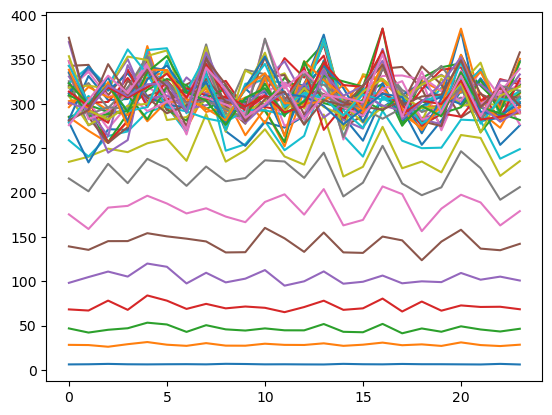

In [72]:
for dt, huh in pl.concat([means_.with_columns(date=pl.lit(date)) for date, means_ in means.items()]).with_columns(pl.col("date").rle_id()).group_by("dt", maintain_order=True):
    plt.plot(huh["date"], huh["msl"])


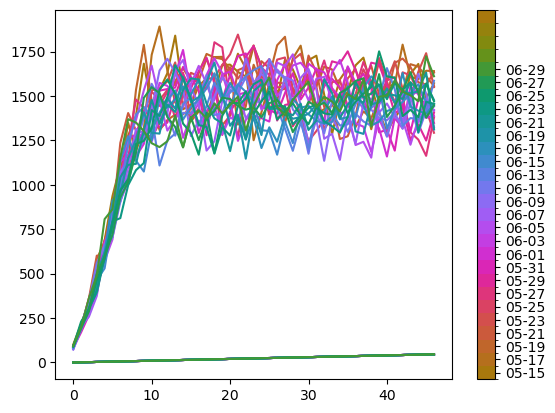

In [64]:
a = list(means)
a.sort()
cmap = colormaps.phase
norm = BoundaryNorm(np.arange(len(a) + 5) - 0.5, cmap.N)
colors = cmap(norm(np.arange(len(a))))
fig, ax = plt.subplots()
for i, b in enumerate(a):
    ax.plot(means[b], color=colors[i], label=b)
im = ScalarMappable(norm, cmap)
cbar = fig.colorbar(im, ax=ax)
_ = cbar.ax.set_yticks(np.arange(len(a)), a)

In [34]:
spatial_mean.with_columns(pl.col("dt") / pl.duration(days=1)).plot.line(x="dt", y="msl")

alt.Chart(...)

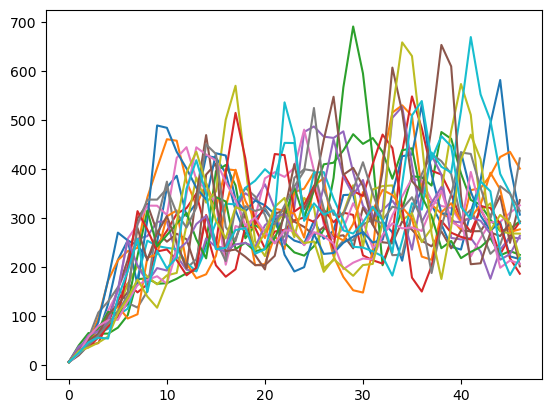

In [11]:
for huh, score_ in score.groupby("time.year"):
    plt.plot(score_.mean(["lon", "lat"]))

In [40]:
score.shape

(940, 31, 39)

In [13]:
import scoringrules as sr

In [ ]:
sr.crps_ensemble()